# Haar Wavelet for Deepfake Detection 

[Click here for the paper](https://ieeexplore.ieee.org/document/9142077)

## Video Deepfake Detection (Haar wavelet approach)
### Importing and installing libraries

In [2]:
!pip install dlib 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 31.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for dlib: filename=dlib-19.24.6-cp310-cp310-linux_x86_64.whl size=3374773 sha256=bcea464a28958aa79b7489eed0a71040c0ae402432f535eaff9e94f1adb940c5
  Stored in directory: /root/.cache/pip/wheels/7c/1d/d1/e69ceb001441acedfa6156acda6c1856699e260ea1a9e6dcc4
Successfully built dlib


In [5]:
# importing all necessary libraries
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import dlib
import pywt
from pathlib import Path
import glob
import argparse
import skimage.measure

In [9]:
# defining all paths
video_path_fake = '/kaggle/input/deepfake/fakevideo.mp4'  
output_dir_fake = 'fake_output_frames'   
video_path_real = '/kaggle/input/deepfake/realvideo.mp4'  
output_dir_real = 'real_output_frames' 
interval = 5  # variable to store how many frames to skip between each extraction

## Extracting frames from video sample

In [10]:
# function to extract frames from the input video at defined interval & storing them in a folder 
def extract_frames(video_path, output_dir, interval):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    frame_count = 0
    saved_frame_count = 0

    while True:
        # Read the next frame from the video
        ret, frame = cap.read()

        # If no more frames are available, break
        if not ret:
            break

        # Save frame only if it's the nth frame, where n is the interval
        if frame_count % interval == 0:
            frame_filename = os.path.join(output_dir, f"frame_{saved_frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            saved_frame_count += 1

        # Update frame count
        frame_count += 1

    # Release the video capture object
    cap.release()
    # print(f"Extracted {saved_frame_count} frames at {interval}-frame intervals to {output_dir}")
    return saved_frame_count

In [11]:
# extracting frames
saved_frame_count_fake = extract_frames(video_path_fake, output_dir_fake, interval)
print("Extracted ", saved_frame_count_fake, " frames")
saved_frame_count_real = extract_frames(video_path_real, output_dir_real, interval)
print("Extracted ", saved_frame_count_real, " frames")

Extracted  444  frames
Extracted  444  frames


## Necessary functions for Blur detection

In [26]:
# pre-trained face detector from dlib
detector = dlib.get_frontal_face_detector()

In [27]:
# function for extracting a bounding box for a given frame (captures the face)
# roi_percentage is used to define what percentage of the default bounding box we want

def extract_bounding_box(rect, roi_percentage):
    # extracting the starting and ending coordinates of the bounding box
    startX = rect.left()
    startY = rect.top()

    # bounding box coordinates should be within the spatial dimensions of the image
    startX = max(0, startX)
    startY = max(0, startY)

    # compute the width and height of the bounding box
    w = rect.width()
    h = rect.height()
    
    # return (startX, startY, w, h)

    # new dimensions for the reduced bounding box
    new_w = int(w * roi_percentage)
    new_h = int(h * roi_percentage)

    # new coordinates to center the smaller bounding box
    new_x = startX + (w - new_w) // 2
    new_y = startY + (h - new_h) // 2

    new_x = max(0, new_x)
    new_y = max(0, new_y)

    return (new_x, new_y, new_w, new_h)

In [28]:
# function used within the main function to apply haar wavelet
def h_w_t(image):
    M, N = image.shape
    image = image[0:int(M/16)*16, 0:int(N/16)*16]
    coeffs = pywt.wavedec2(image, wavelet='haar', level=3)
    approx,level_3,level_2,level_1 = coeffs
    return approx,level_1,level_2,level_3
    
def construct_edge_maps(level_1,level_2,level_3):
    E_1 = np.sqrt(level_1[0]**2 + level_1[1]**2 + level_1[2]**2)
    E_2 = np.sqrt(level_2[0]**2 + level_2[1]**2 + level_2[2]**2)
    E_3 = np.sqrt(level_3[0]**2 + level_3[1]**2 + level_3[2]**2)
    return E_1,E_2,E_3

## General blur detection algorithm

In [29]:
#  main function : gives the Per (defined in the report) and blur extent values for an image 
def blur_detect(img, threshold):
    Y = img
    M, N = Y.shape

    # cropping input image to be divisible by 2
    Y = Y[0:int(M/16)*16, 0:int(N/16)*16]
    
    # Step 1: computing haar wavelet of input image
    approx,level_1,level_2,level_3 = h_w_t(Y)
    
    # Step 2: computing the edge map in each scale 
    E1, E2, E3 = construct_edge_maps(level_1,level_2,level_3)
    
    M1, N1 = E1.shape

    # sliding window size level 1
    sizeM1 = 8
    sizeN1 = 8
    
    # sliding windows size level 2
    sizeM2 = int(sizeM1/2)
    sizeN2 = int(sizeN1/2)
    
    # sliding windows size level 3
    sizeM3 = int(sizeM2/2)
    sizeN3 = int(sizeN2/2)
    
    # number of edge maps, related to sliding windows size
    N_iter = int((M1/sizeM1)*(N1/sizeN1))
    
    Emax1 = np.zeros((N_iter))
    Emax2 = np.zeros((N_iter))
    Emax3 = np.zeros((N_iter))
    
    count = 0
    
    # sliding windows index of level 1
    x1 = 0
    y1 = 0
    # sliding windows index of level 2
    x2 = 0
    y2 = 0
    # sliding windows index of level 3
    x3 = 0
    y3 = 0
    
    # sliding windows limit on horizontal dimension
    Y_limit = N1 - sizeN1
    
    while count < N_iter:
        # maximum value of slicing windows over edge maps in each level
        Emax1[count] = np.max(E1[x1:x1+sizeM1,y1:y1+sizeN1])
        Emax2[count] = np.max(E2[x2:x2+sizeM2,y2:y2+sizeN2])
        Emax3[count] = np.max(E3[x3:x3+sizeM3,y3:y3+sizeN3])
        
        # if sliding windows ends horizontal direction then move along vertical direction 
        # and reset horizontal direction
        if y1 == Y_limit:
            x1 = x1 + sizeM1
            y1 = 0
            
            x2 = x2 + sizeM2
            y2 = 0
            
            x3 = x3 + sizeM3
            y3 = 0
            
            count += 1
        
        # windows moves along horizontal dimension
        else:
                
            y1 = y1 + sizeN1
            y2 = y2 + sizeN2
            y3 = y3 + sizeN3
            count += 1
    
    # Step 3:
    EdgePoint1 = Emax1 > threshold;
    EdgePoint2 = Emax2 > threshold;
    EdgePoint3 = Emax3 > threshold;
    
    # Rule 1: Edge Pojnts
    EdgePoint = EdgePoint1 + EdgePoint2 + EdgePoint3
    n_edges = EdgePoint.shape[0]
    
    # Rule 2: Dirac-Structure or Astep-Structure
    DAstructure = (Emax1[EdgePoint] > Emax2[EdgePoint]) * (Emax2[EdgePoint] > Emax3[EdgePoint]);
    # print(DAstructure)
    
    # Rule 3: Roof-Structure or Gstep-Structure
    RGstructure = np.zeros((n_edges))
    for i in range(n_edges):
        if EdgePoint[i] == 1:
            if Emax1[i] < Emax2[i] and Emax2[i] < Emax3[i]:
                RGstructure[i] = 1
                
    # Rule 4: Roof-Structure
    RSstructure = np.zeros((n_edges))
    for i in range(n_edges): 
        if EdgePoint[i] == 1: 
            if Emax2[i] > Emax1[i] and Emax2[i] > Emax3[i]:   
                RSstructure[i] = 1

    # Rule 5: Edge more likely to be in a blurred image 
    BlurC = np.zeros((n_edges));
    for i in range(n_edges):
        if RGstructure[i] == 1 or RSstructure[i] == 1:
            if Emax1[i] < threshold:
                BlurC[i] = 1                        
        
    # Step 6
    Per = np.sum(DAstructure)/np.sum(EdgePoint)
    
    # Step 7
    if (np.sum(RGstructure) + np.sum(RSstructure)) == 0:
        BlurExtent = 100
    else:
        BlurExtent = np.sum(BlurC) / (np.sum(RGstructure) + np.sum(RSstructure))

    # print("Total edges " ,n_edges," DA ",np.sum(DAstructure)," Roof or G",np.sum(RGstructure),
    # " Roof ",np.sum(RSstructure)," Blur ",np.sum(BlurC))
    
    return Per, BlurExtent, Emax1, Emax2, Emax3

## Functions for the algorithm of deepfake detection using Haar Wavelet Transform

In [30]:
# Step 1: Detect faces and extract ROI 
def extract_roi(image, roi_percentage):
    faces = detector(image)
    rois = []
    for face in faces:
        box = extract_bounding_box(face, roi_percentage)
        new_x, new_y, new_w, new_h = box

        if new_w > 0 and new_h > 0:
            roi = image[new_y:new_y+new_h, new_x:new_x+new_w]
            rois.append(roi)
    return rois

In [31]:
# function that takes an image path as an input and then give a result whether its fake or not
def detect_deepfake(img_path, roi_percentage):
    ans = False
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rois = extract_roi(img, roi_percentage)
    if len(rois) == 0:
        # print("No faces detected.")
        return
        
    Per_soc, Blur_extent_soc, Emax1, Emax2, Emax3 = blur_detect(img,35)
    for i, roi in enumerate(rois):
        # check if the ROI is valid before further processing
        if roi is None or roi.size == 0:
            # print(f"Skipping invalid face ROI {i+1}")
            continue
            
        Per, Blur_extent, Emax1_roi, Emax2_roi, Emax3_roi = blur_detect(roi,35)
        
        # before this if we can tune the MZero value then if may set an outer if 
        # condition, which will allow us to first check potential deep fake , then 
        # do blur comparision for detecting whether its actual deep fake or not 
        
        MZero = 0.05 # Cutoff for declaring blur
        if(Per > MZero):
            ans = ans
            # print(f"Face {i+1} seems real: Blur not detected as per Mzero cutoff. Blur= {Blur_extent} Blur_soc = {Blur_extent_soc}")
        else:   
            if(Blur_extent > Blur_extent_soc):
                ans = True
                # print(f"DeepFake suspected in face {i+1}: ROI blur > SOC blur. Blur= {Blur_extent} Blur_soc = {Blur_extent_soc}")
            else:
                ans = ans
                # print(f"Face {i+1} seems real: Blur consistent . Blur= {Blur_extent} Blur_soc = {Blur_extent_soc}")  
    return ans


In [32]:
# final pipeline function : returns the probability of video being Deep Fake
def video_deep_detect(video_path, output_dir, interval, roi_percentage):
    frames_num = extract_frames(video_path, output_dir, interval)
    directory_path = Path(f"/kaggle/working/{output_dir}")
    count = 0
    total_count = 0
    for file_path in directory_path.iterdir():
        if(detect_deepfake(file_path, roi_percentage)):
            count+=1
        total_count+=1
    # files = glob.glob(f"/kaggle/working/{output_dir}/*")
    # for f in files:
    #     os.remove(f)
    # print((count/total_count)*100, "% Confidence that Video is Fake")
    return count/total_count, frames_num
    

## Functions for various visualizations

In [58]:
# visualizing and checking the bounding box for the randomly chosen frame
def visualize_bounding_box(image_path, roi_percentage):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    rects = detector(image_rgb)
    # experimentally, this is the best percentage of ROI we should take
    
    boxes = [extract_bounding_box(r, roi_percentage) for r in rects]
    
    for (x, y, w, h) in boxes:
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 4)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Detected face in the frame')
    plt.show()

In [41]:
# function to visualize haar wavelet coefficents 
def plot_coeffs(cA, details, level):
    cH, cV, cD = details
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    titles = ['Approximation', 'Horizontal Detail', 'Vertical Detail', 'Diagonal Detail']
    
    # approximation
    axes[0, 0].imshow(cA, cmap='gray')
    axes[0, 0].set_title(f'{titles[0]} Level {level}')
    axes[0, 0].axis('off')
    
    # horizontal detail
    axes[0, 1].imshow(cH, cmap='gray')
    axes[0, 1].set_title(f'{titles[1]} Level {level}')
    axes[0, 1].axis('off')
    
    # vertical detail
    axes[1, 0].imshow(cV, cmap='gray')
    axes[1, 0].set_title(f'{titles[2]} Level {level}')
    axes[1, 0].axis('off')
    
    # diagonal detail
    axes[1, 1].imshow(cD, cmap='gray')
    axes[1, 1].set_title(f'{titles[3]} Level {level}')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [42]:
# function to visualize edge maps
def plot_edge_maps(E_1, E_2, E_3):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
    titles = ['Edge Map Level 1', 'Edge Map Level 2', 'Edge Map Level 3']
    
    # Plot each edge map
    axes[0].imshow(E_1, cmap='gray')
    axes[0].set_title(titles[0])
    axes[0].axis('off')
    
    axes[1].imshow(E_2, cmap='gray')
    axes[1].set_title(titles[1])
    axes[1].axis('off')
    
    axes[2].imshow(E_3, cmap='gray')
    axes[2].set_title(titles[2])
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [43]:
# function to visualize max-pooled edge maps
def max_pooled_edge_maps(E1, E2, E3, sizeM1, sizeN1, sizeM2, sizeN2, sizeM3, sizeN3):
    # Initialize max-pooled edge maps with zeros
    M1, N1 = E1.shape
    max_pooled_E1 = np.zeros_like(E1)
    max_pooled_E2 = np.zeros_like(E2)
    max_pooled_E3 = np.zeros_like(E3)

    # Sliding windows indices
    x1, y1 = 0, 0
    x2, y2 = 0, 0
    x3, y3 = 0, 0

    # Sliding windows limit on horizontal dimension
    Y_limit = N1 - sizeN1
    
    count = 0
    N_iter = int((M1 / sizeM1) * (N1 / sizeN1))
    
    while count < N_iter:
        # Max pooling over sliding windows
        max_pooled_E1[x1:count, y1:count] = np.max(E1[x1:x1 + sizeM1, y1:y1 + sizeN1])
        max_pooled_E2[x2:count, y2:count] = np.max(E2[x2:x2 + sizeM2, y2:y2 + sizeN2])
        max_pooled_E3[x3:count, y3:count] = np.max(E3[x3:x3 + sizeM3, y3:y3 + sizeN3])

        # Check if sliding window ends on the horizontal dimension
        if y1 == Y_limit:
            x1, y1 = x1 + sizeM1, 0
            x2, y2 = x2 + sizeM2, 0
            x3, y3 = x3 + sizeM3, 0
        else:
            y1, y2, y3 = y1 + sizeN1, y2 + sizeN2, y3 + sizeN3

        count += 1

    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(max_pooled_E1, cmap='gray')
    axes[0].set_title('Max-Pooled Edge Map 1')
    
    axes[1].imshow(max_pooled_E2, cmap='gray')
    axes[1].set_title('Max-Pooled Edge Map 2')
    
    axes[2].imshow(max_pooled_E3, cmap='gray')
    axes[2].set_title('Max-Pooled Edge Map 3')
    
    for ax in axes:
        ax.axis('off')
    
    plt.show()
    
    return max_pooled_E1,max_pooled_E2,max_pooled_E3

In [44]:
# function to classify the edge points into different edge types and visualize them
def classify_and_visualize_edges(Emax1, Emax2, Emax3, threshold):
    # Step 1: Detect edge points based on threshold
    EdgePoint1 = Emax1 > threshold
    EdgePoint2 = Emax2 > threshold
    EdgePoint3 = Emax3 > threshold
    
    # Rule 1: Combined Edge Points
    EdgePoint = EdgePoint1 | EdgePoint2 | EdgePoint3  # Logical OR for edge existence in any level
    
    # Step 2: Classify edges
    DAstructure = (Emax1 > Emax2) & (Emax2 > Emax3)  # Dirac/Astep-Structure
    RGstructure = (Emax1 < Emax2) & (Emax2 < Emax3)  # Gstep-Structure
    RSstructure = (Emax2 > Emax1) & (Emax2 > Emax3)  # Roof-Structure
    
    # Step 3: Visualization
    plt.figure(figsize=(12, 6))
    
    # Visualize Original Edge Maps
    plt.subplot(1, 2, 1)
    plt.title("Original Edge Map (Emax1)")
    plt.imshow(Emax1, cmap='gray')
    
    # Overlay Classification Map
    plt.subplot(1, 2, 2)
    plt.title("Classified Edges")
    
    # Create a color map for classified edges
    classified_edges = np.zeros((Emax1.shape[0], Emax1.shape[1], 3))  # RGB channels
    
    # Assign colors to different edge categories
    classified_edges[DAstructure] = [1, 0, 0]  # Red for Dirac/Astep
    classified_edges[RGstructure] = [0, 1, 0]  # Green for Gstep
    classified_edges[RSstructure] = [0, 0, 1]  # Blue for Roof
    
    # Overlay classified edges on the original image
    plt.imshow(classified_edges)
    
    # Show the plot
    plt.show()

## Visualizations 

In [60]:
# choosing a random frame from the extracted frames of a sample video
frame_path = '/kaggle/working/real_output_frames/frame_0060.jpg' 

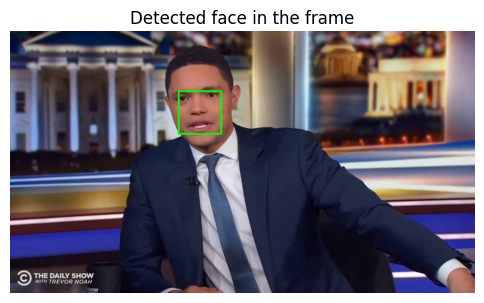

In [61]:
visualize_bounding_box(frame_path, 0.65)

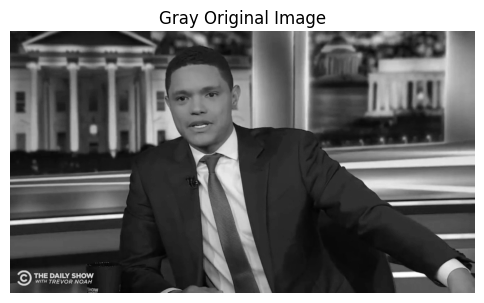

In [47]:
# creating a modified grayscale image on which haar wavelet transform can be applied 
image = cv2.imread(frame_path)
image = image.mean(axis=2)

# visualizing the grayscale image
plt.figure(figsize=(6,6))
plt.imshow(image, cmap='gray')
plt.title('Gray Original Image')
plt.axis('off')
plt.show()

In [48]:
# apply haar wavelet transform
approx,level_1,level_2,level_3 = h_w_t(image)

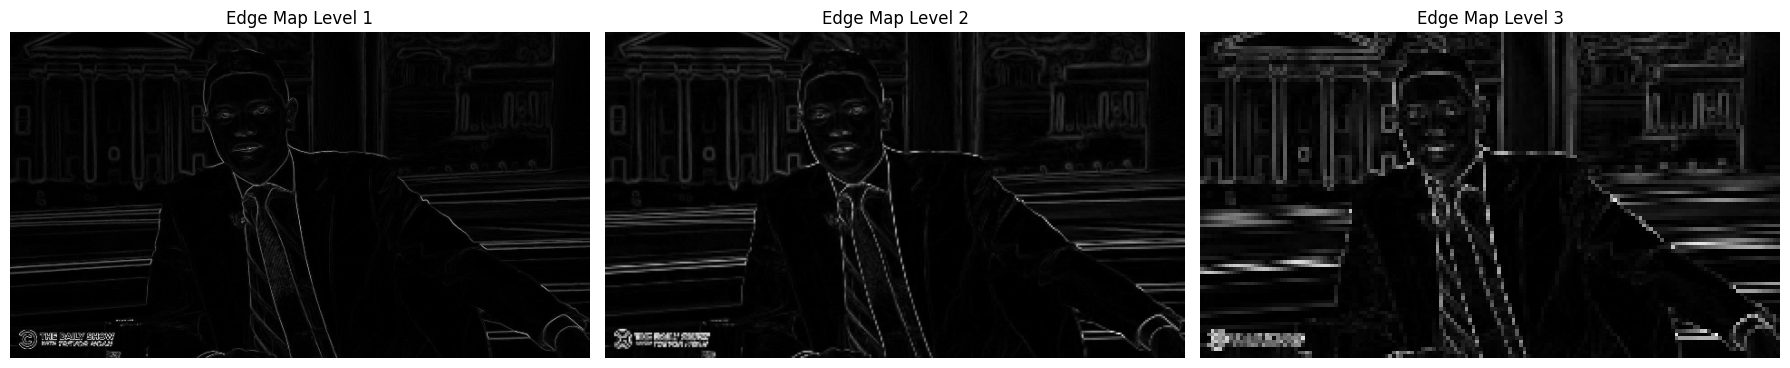

In [49]:
# finding edge maps
E_1, E_2, E_3 = construct_edge_maps(level_1, level_2, level_3)
plot_edge_maps(E_1, E_2, E_3)

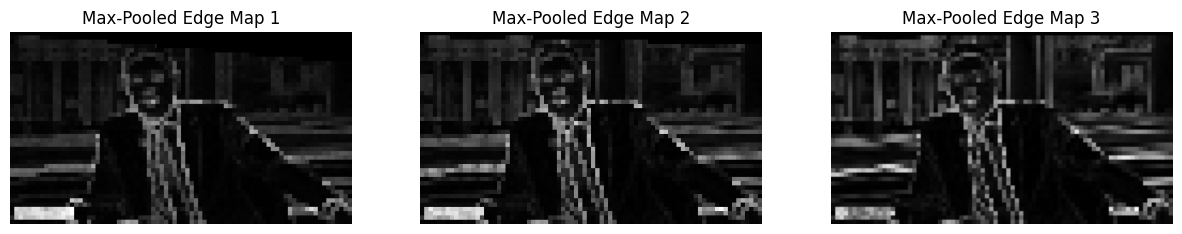

In [50]:
Emax1, Emax2 , Emax3 = max_pooled_edge_maps(E_1, E_2, E_3, 8, 8, 4, 4, 2, 2)

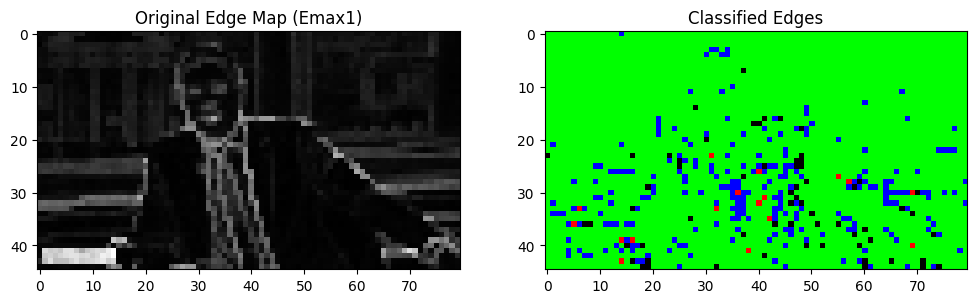

In [51]:
# Red for Dirac/Astep
# Green for Gstep
# Blue for Roof
Per, BlurExtent, Emax1, Emax2, Emax3 = blur_detect(image, 35)
t = image.shape
x = int(t[0]/16)
y = int(t[1]/16)
Emax1_reshaped = Emax1.reshape(x,y)
Emax2_reshaped = Emax2.reshape(x,y)
Emax3_reshaped = Emax3.reshape(x,y)
classify_and_visualize_edges(Emax1_reshaped, Emax2_reshaped, Emax3_reshaped, threshold= 35)

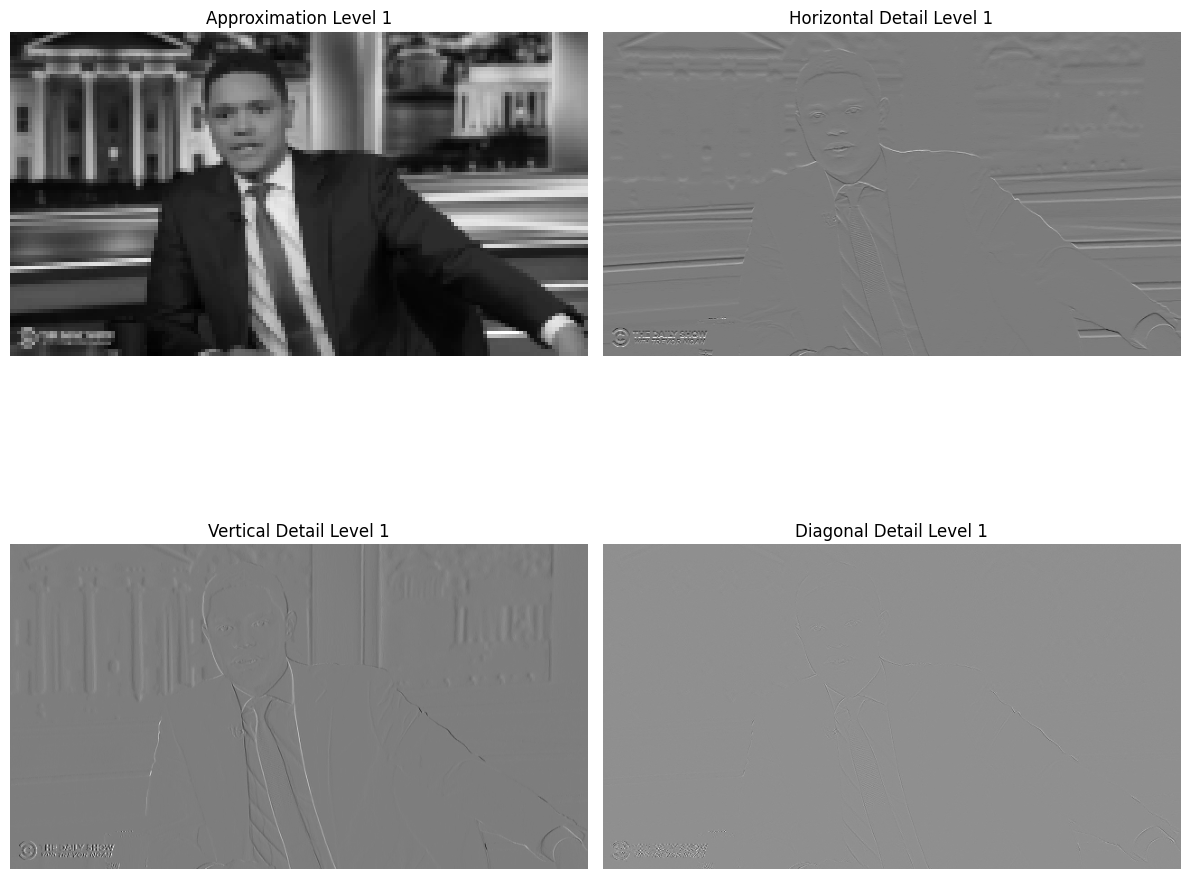

In [52]:
cA = approx
cH, cV, cD = level_1  # level 1
plot_coeffs(cA, (cH, cV, cD), level=1) 

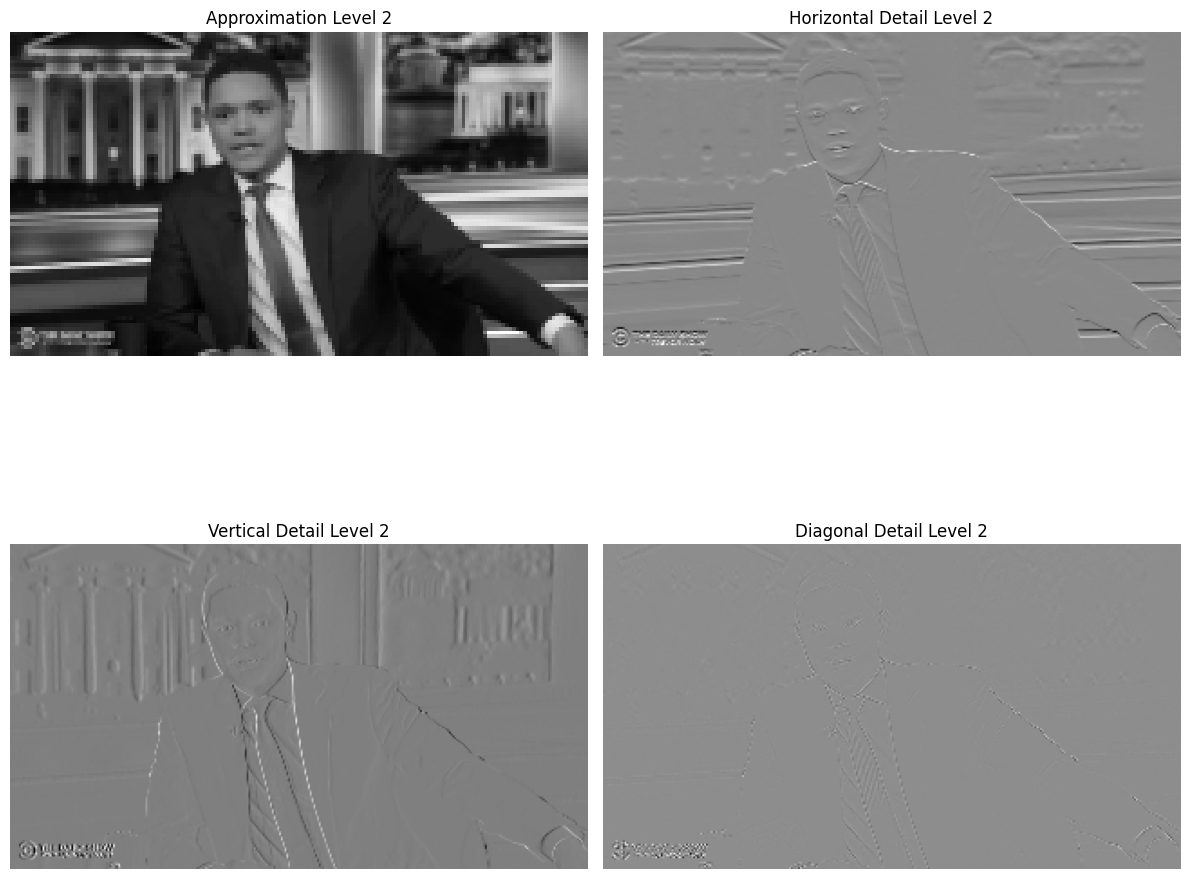

In [53]:
cA = approx
cH, cV, cD = level_2  # level 2
plot_coeffs(cA, (cH, cV, cD), level=2) 

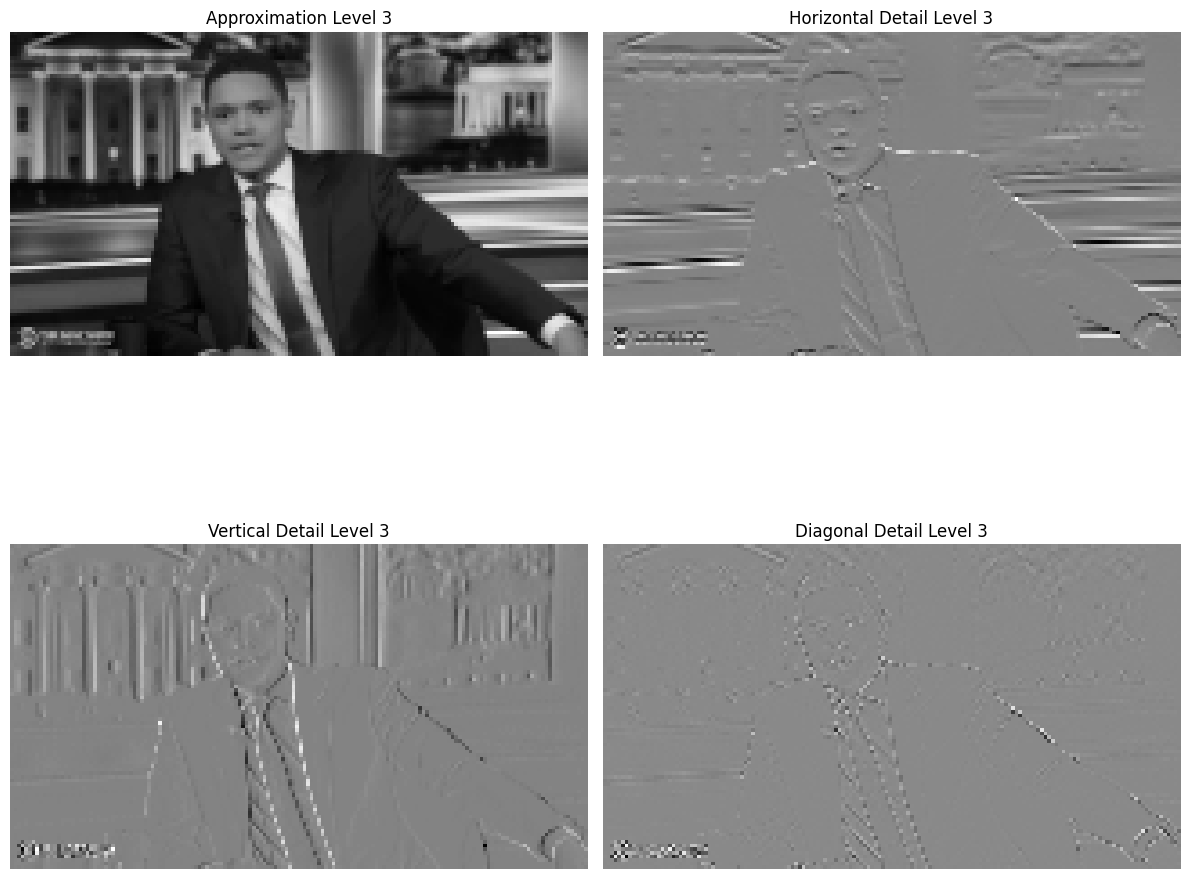

In [54]:
cA = approx
cH, cV, cD = level_3  # level 3
plot_coeffs(cA, (cH, cV, cD), level=3) 

## Testing the algorithm on a real and fake video at different ROI percentages

In [79]:
fake_path = '/kaggle/input/deepfake/fakevideo.mp4'
real_path = '/kaggle/input/deepfake/realvideo.mp4'

interval = 5
# manually decide the size of the ROI box (reduce original dlib box size)
roi_percentage_list = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
threshold = 0.4

for i in roi_percentage_list:
    print(f"For {int(i*100)}% ROI:")
    percentage_real, frame = video_deep_detect(real_path, 'test_frames' , interval, i)
    print("Fake percentage on real video:", percentage_real*100)

    percentage_fake, frame = video_deep_detect(fake_path, 'test_frames', interval, i)
    print("Fake percentage on fake video:", percentage_fake*100, "\n")
    files = glob.glob("/kaggle/working/test_frames/*")
    for f in files:
        os.remove(f)
    os.rmdir("/kaggle/working/test_frames")

print("For 100% ROI:")
percentage_real, frame = video_deep_detect(real_path, 'test_frames', interval, 1)
print("Fake percentage on real video:", percentage_real*100)

files = glob.glob("/kaggle/working/test_frames/*")
for f in files:
    os.remove(f)
os.rmdir("/kaggle/working/test_frames")

percentage_fake, frame = video_deep_detect(fake_path, 'test_frames', interval, 1)
print("Fake percentage on fake video:", percentage_fake*100, "\n")

files = glob.glob("/kaggle/working/test_frames/*")
for f in files:
    os.remove(f)
os.rmdir("/kaggle/working/test_frames")


For 25% ROI:
Fake percentage on real video: 68.69369369369369
Fake percentage on fake video: 95.4954954954955 

For 35% ROI:
Fake percentage on real video: 51.35135135135135
Fake percentage on fake video: 96.62162162162163 

For 45% ROI:
Fake percentage on real video: 31.08108108108108
Fake percentage on fake video: 97.52252252252252 

For 55% ROI:
Fake percentage on real video: 32.65765765765766
Fake percentage on fake video: 96.84684684684684 

For 65% ROI:
Fake percentage on real video: 27.25225225225225
Fake percentage on fake video: 97.07207207207207 

For 75% ROI:
Fake percentage on real video: 31.98198198198198
Fake percentage on fake video: 96.62162162162163 

For 85% ROI:
Fake percentage on real video: 37.16216216216216
Fake percentage on fake video: 96.17117117117117 

For 95% ROI:
Fake percentage on real video: 43.69369369369369
Fake percentage on fake video: 97.07207207207207 

For 100% ROI:
Fake percentage on real video: 45.4954954954955
Fake percentage on fake video: 96.6

## Visualizing the frame with optimal ROI and 100% ROI

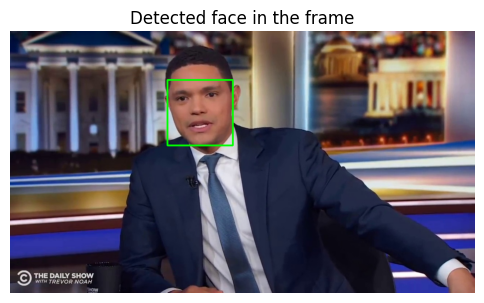

In [82]:
# visualize and check the bounding box for chosen frame with ROI percentage 100%
frame_path = "/kaggle/working/real_output_frames/frame_0060.jpg"
visualize_bounding_box(frame_path, 1)

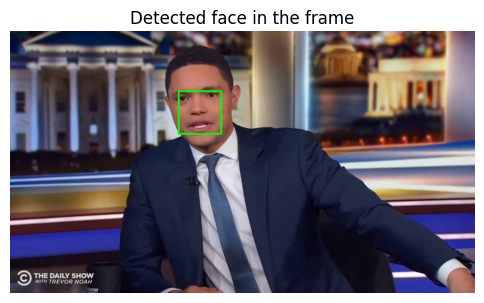

In [83]:
# visualize and check the bounding box for chosen frame with ROI percentage 65%
visualize_bounding_box(frame_path, 0.65)

## Various Metrics

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [85]:
# functions to calculate metrics for a given fake and real video 
# we have checked this method for a real video and a fake video generated using the real one
def get_labels_and_scores(real, fake, output_dir, interval, roi_percentage):
    labels = []
    scores = []
    accuracy, frames = video_deep_detect(real, output_dir, interval, roi_percentage)
    for i in range(frames):
        scores.append(accuracy)
        labels.append(0)  # label real videos as 0

    accuracy, frames = video_deep_detect(fake, output_dir, interval, roi_percentage)
    for i in range(frames):
        scores.append(accuracy)
        labels.append(1)  # label fake videos as 1

    return labels, scores

def calculate_metrics(real, fake, output_dir, interval, roi_percentage, threshold):
    labels, scores = get_labels_and_scores(real, fake, output_dir, interval, roi_percentage)

    # converting soft probabilities into binary predictions using the threshold
    predictions = [1 if score > threshold else 0 for score in scores]

    # Metrics: accuracy, precision, recall, F1 score
    accuracy = accuracy_score(labels,predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return accuracy, precision, recall, f1

In [96]:
# functions to calculate metrics for all videos in a given directory/dataset folder
def get_videos_from_directory(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

def get_labels_and_scores_dataset(real_dir, fake_dir, output_dir, interval, roi_percentage):
    real_videos = get_videos_from_directory(real_dir)
    fake_videos = get_videos_from_directory(fake_dir)
    labels = []
    scores = []
    for video_path in real_videos:
        score, frames = video_deep_detect(video_path, output_dir, interval, roi_percentage)
        scores.append(score)
        labels.append(0)  # label real videos as 0

    for video_path in fake_videos:
        score, frames = video_deep_detect(video_path, output_dir, interval, roi_percentage)
        scores.append(score)
        labels.append(1)  # label fake videos as 1

    return labels, scores

def calculate_metrics_dataset(real_dir, fake_dir, output_dir, interval, roi_percentage, threshold=0.4):
    labels, scores = get_labels_and_scores_dataset(real_dir, fake_dir, output_dir, interval, roi_percentage)

    # convert soft probabilities into binary predictions using the threshold
    predictions = [1 if score > threshold else 0 for score in scores]
    
    # Metrics: accuracy, precision, recall, F1 score
    accuracy = accuracy_score(labels,predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return accuracy, precision, recall, f1,labels,scores

### Testing on UADFV dataset

In [ ]:
real_dir_uadfv = '/kaggle/input/uadfv-new/uadfv/real'
fake_dir_uadfv = '/kaggle/input/uadfv-new/uadfv/fake'
output_dir = 'uadfv_test'
interval = 1
i = 0.65
threshold = 0.4

accuracy, precision, recall, f1,labels,scores = calculate_metrics_dataset(real_dir_uadfv, fake_dir_uadfv, output_dir, interval, i, threshold)
print(f"\n Video-wise metrics for 65% ROI on UADFV Dataset:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1} \n")

### Testing on celeb-df-v1 dataset

In [ ]:
real_dir_celeb = '/kaggle/input/celebdfv1-new/train/real'
fake_dir_celeb = '/kaggle/input/celebdfv1-new/train/fake'
output_dir = 'celebfv1_test'
interval = 5
i = 0.65
threshold = 0.4

accuracy, precision, recall, f1,labels,scores = calculate_metrics_dataset(real_dir_celeb, fake_dir_celeb, output_dir, interval, i, threshold)
print(f"\n Video-wise metrics for 65% ROI on Celeb-df-v1 Dataset:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1} \n")

## Image Deepfake Detection

In [ ]:
image_path = '/kaggle/input/real-fake-images/real_1.jpeg'

In [ ]:
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

rects = detector(image_rgb)
roi_percentage = 0.65
boxes = [extract_bounding_box(r, roi_percentage) for r in rects]

# visualizing the detected faces
for (x, y, w, h) in boxes:
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2) 

# displaying the image with detected faces
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.title('Detected Faces')
plt.show()

In [ ]:
# finding haar wavelet coefficients 
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = image.astype(np.float32)
approx,level_3,level_2,level_1 = h_w_t(image)

In [ ]:
# finding edge maps
E_1, E_2, E_3 = construct_edge_maps(level_1, level_2, level_3)

In [ ]:
# plotting everything
plot_edge_maps(E_1, E_2, E_3)

In [ ]:
cA = approx
cH, cV, cD = level_1  # level of choice
plot_coeffs(cA, (cH, cV, cD), level=1) 

In [ ]:
cA = approx
cH, cV, cD = level_2  # level of choice
plot_coeffs(cA, (cH, cV, cD), level=2) 

In [ ]:
cA = approx
cH, cV, cD = level_3  # level of choice
plot_coeffs(cA, (cH, cV, cD), level=3) 

In [ ]:
# testing on a real image
image_path = '/kaggle/input/real-fake-images/real_2.jpg'
detect_deepfake(image_path, 0.65)

In [ ]:
# testing on a fake image
image_path = '/kaggle/input/real-fake-images/fake_1.jpeg'
detect_deepfake(image_path, 0.65)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# functions to calculate metrics for all images in a given directory
def get_images_from_directory(directory):
    return [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

def get_labels_and_scores(real_dir, fake_dir):
    real_images = get_images_from_directory(real_dir)
    fake_images = get_images_from_directory(fake_dir)

    labels = []
    scores = []

    for image_path in real_images:
        score = detect_deepfake(image_path)
        scores.append(score)
        labels.append(0)  # Label real videos as 0

    for image_path in fake_images:
        score = detect_deepfake(image_path)
        scores.append(score)
        labels.append(1)  # Label fake videos as 1

    return labels, scores

def calculate_metrics(real_dir, fake_dir, threshold=0.4):
    labels, scores = get_labels_and_scores(real_dir, fake_dir)

    # converting soft probabilities into binary predictions using the threshold
    predictions = [1 if score > threshold else 0 for score in scores]
    
    # Metrics: accuracy, precision, recall, F1 score
    accuracy = accuracy_score(labels,predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return accuracy, precision, recall, f1